
# From baseline measurements and time till last visit try to predict disease progression in the future

 Disease progression defined as diagnosis on last visit being worse than the baseline diagnosis


# 1 Data loading, preperation and cleaning

In [130]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")
sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.base import clone

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [42]:
adni_df = pd.read_csv("ADNIMERGE.csv")
print(adni_df.shape)
adni_df.head(3)

(13673, 113)


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,mPACCdigit,mPACCtrailsB,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.36665,NaN,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,CN,-4.35795,-4.15975,2005-09-08,0.0,10.67,18.67,5.0,28,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,-4.35795,-4.15975,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2018-11-08 22:51:22.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.08355,NaN,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,Dementia,-16.58450,-16.16580,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2018-11-08 22:51:22.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.05803,NaN,NaN,NaN,NaN,NaN,6.0,19.00,30.00,10.0,24.0,19.0,2.0,6.0,100.0000,NaN,19.0,135.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,31863.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,Dementia,-15.02030,-13.38660,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2018-11-08 22:51:22.0


In [3]:
adni_df['DX_bl'].fillna('NONE', inplace=True)
adni_df['DX'].fillna('NONE', inplace=True)
display(adni_df['DX_bl'].value_counts())
display(adni_df['DX'].value_counts())

LMCI    4819
CN      4125
EMCI    2488
AD      1576
SMC      648
NONE      17
Name: DX_bl, dtype: int64

MCI         4288
NONE        3982
CN          3223
Dementia    2180
Name: DX, dtype: int64

In [4]:
adni1_df = adni_df[adni_df['ORIGPROT'] == 'ADNI1'].copy()
df = adni1_df.copy()
print(df['DX_bl'].unique())
print(df['DX'].unique())

['CN' 'AD' 'LMCI']
['CN' 'Dementia' 'MCI' 'NONE']


In [5]:
print('Before dropping: ' , df.shape)
df['DX'] = df['DX'].replace(to_replace='NONE', value=np.nan)
df=df.dropna(axis=0, subset=['DX'])
print('After dropping: ' , df.shape)
print(df['DX'].unique())

Before dropping:  (7066, 113)
After dropping:  (5059, 113)
['CN' 'Dementia' 'MCI']


## 1.1 Limit your data for each individual to their last visit and baseline information

In [6]:
# All the different visits for our first patient ID
df[df.PTID=='011_S_0002' ]['M']

0          0
5109       6
5110      36
5111      60
11174    120
11177     96
11179     84
11181     72
11445    132
11446    144
Name: M, dtype: int64

In [7]:
# The different unique patient ID
len(df.PTID.unique())

819

In [8]:
# The different unique patient ID
df.M.unique()

array([  0,   6,  12,  24,  18,  36,  48,  60,  72, 108,  96,  84, 120,
       132, 144, 156])

In [9]:
indexes_last_visit=[]
for patient_ids in df.PTID.unique():
  latest_visit_M=df[df.PTID==patient_ids]['M'].max()
  d=df[ df.PTID==patient_ids ]['M']== latest_visit_M
  ind=d.index[-1]
  indexes_last_visit.append(ind);
  
# Only last visits
df_last=df.loc[indexes_last_visit]

In [10]:
diction_last_DX={}
for D in df_last['DX'].unique():
  diction_last_DX[D]=df_last[df_last['DX']==D]['M']/12
  
diction_first_DX={}
for D in df_last['DX_bl'].unique():
  diction_first_DX[D]=df_last[df_last['DX_bl']==D]['M']/12

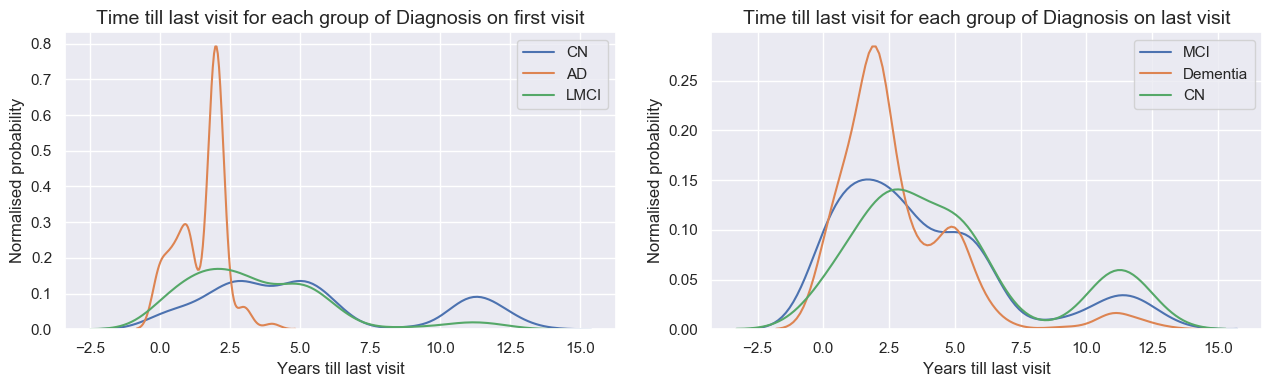

In [131]:
fig, axs= plt.subplots(1,2, figsize=(13,4))
ax=axs.ravel()
for key, val in diction_first_DX.items():
  sns.kdeplot(val, label=key, ax= ax[0])
  ax[0].set_title('Time till last visit for each group of Diagnosis on first visit')
  ax[0].set_xlabel('Years till last visit')
  ax[0].set_ylabel('Normalised probability')
  ax[0].legend()
for key, val in diction_last_DX.items():
  sns.kdeplot(val, label=key, ax= ax[1])
  ax[1].set_title('Time till last visit for each group of Diagnosis on last visit')
  ax[1].set_xlabel('Years till last visit')
  ax[1].set_ylabel('Normalised probability')
  ax[1].legend()
plt.tight_layout()

## 1.2 Dropping duplicates and last visit measurements except time and diagnosis 
- Dropping meaningless/duplicate features 
- Keep all features of baseline visit
- Drop all features of the last visist except time till last visit and diagnosis

In [132]:
df=df_last
df.head()

# dealing with the '<' and '>' in abeta and tau and ptau
genes = ['TAU_bl', 'ABETA_bl', 'PTAU_bl']
for val in genes:
    all_vals = df[val].values
    df = df.drop(val, axis=1)
    df[val] = [float(str(x).replace('<','').replace('>','')) for x in all_vals]

# drop collinear, unrelated or missing variables
collinear = ['VISCODE', 'update_stamp', 'Month', 'Month_bl', 'Years_bl']
unrelated = ['RID', 'PTID', 'SITE', 'ORIGPROT', 'COLPROT', 'FSVERSION','FSVERSION_bl', 'IMAGEUID', 'FLDSTRENG','FLDSTRENG_bl', 'EXAMDATE' ,  'EXAMDATE_bl']
baselines = []
nulls = dict(df.isna().sum().sort_values())
null_cols = []
drop_non_bl=['FDG', 'PIB', 'AV45', 'ABETA',
             'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
             'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
             'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR',
             'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat',
             'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal',
             'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
             'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG',
             'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain',
             'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'mPACCdigit',
             'mPACCtrailsB']

empty=['MOCA_bl', 'EcogSPTotal_bl', 'EcogPtVisspat_bl', 'EcogPtPlan_bl','EcogPtOrgan_bl','EcogPtDivatt_bl',
       'EcogPtTotal_bl','EcogSPMem_bl','EcogSPLang_bl','EcogSPVisspat_bl',
       'EcogSPPlan_bl','EcogSPOrgan_bl','EcogSPDivatt_bl', 'AV45_bl', 'EcogPtMem_bl', 'EcogPtLang_bl'] 

# filling out null_cols and baselines
for i in df.columns.values:
    if '_bl' in i or '_BL' in i:
        baselines.append(i)
    elif nulls[i] > df.shape[0]/1.1:
        baselines.append(i)
        
df = df.drop(collinear + unrelated + null_cols + drop_non_bl + empty, axis=1)

# dealing with categorical variables
df['PTGENDER'] = (df['PTGENDER'] == 'Female')*1

categoricals = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
dummies = pd.get_dummies(df[categoricals])
df = pd.concat([df, dummies], axis=1)

# more informative names
df = df.rename(index=str, columns={"PTGENDER": "PTGENDER_Female"})

# drop categoricals
df = df.drop(categoricals, axis=1)

# making the 'DX' variable numeric
df['DX'] = df['DX'].map({'CN': 1, 'MCI': 2, 'Dementia': 3})
df['DX_bl'] = df['DX_bl'].map({'CN': 1, 'LMCI': 2, 'AD': 3})

# dropping rows that are missing the response variable
df = df.dropna(subset=['DX'])
df = df.dropna(subset=['DX_bl'])

display(df.shape)
df.head()

(819, 47)

,DX_bl,AGE,PTGENDER_Female,PTEDUCAT,APOE4,DX,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,PIB_bl,M,TAU_bl,ABETA_bl,PTAU_bl,PTETHCAT_Hisp/Latino,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_White,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
11446,1,74.3,0,16,0.0,2,0.0,10.67,18.67,5.0,28,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,-4.35795,-4.15975,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,1.36665,NaN,144,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,1,0,0,0
4,3,81.3,0,18,1.0,3,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,1.08355,NaN,24,239.7,741.5,22.83,0,1,0,0,0,0,0,1,0,1,0,0,0
9,2,67.5,0,10,0.0,2,1.0,14.33,21.33,6.0,27,37.0,7.0,4.0,36.3636,4.0,25.0,271.0,0.0,-8.49902,-9.52048,39605.0,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,NaN,NaN,36,153.1,1501.0,13.29,1,0,0,0,0,0,0,1,0,1,0,0,0
14,1,73.7,0,16,0.0,1,0.0,8.67,14.67,4.0,29,37.0,4.0,4.0,44.4444,12.0,38.0,90.0,0.0,-1.90246,-1.57826,34062.0,7075.0,1116630.0,4433.0,24788.0,21614.0,1640770.0,1.29343,NaN,36,337.0,547.3,33.43,0,1,0,0,0,0,0,1,0,1,0,0,0
5122,2,80.4,1,13,0.0,2,0.5,18.67,25.67,7.0,25,30.0,1.0,5.0,83.3333,3.0,34.0,168.0,0.0,-10.29260,-11.05750,39826.0,5348.0,927510.0,2277.0,17963.0,17802.0,1485830.0,NaN,NaN,24,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,1,0,0,0


## 1.3 Missing value imputation by 5 KNN

In [13]:
# imputation through kNN with 5 neighbors

null_df = pd.DataFrame(df.isna().sum().sort_values(), columns=['Nulls'])
new_nulls = null_df[null_df['Nulls'] > 0].to_dict()['Nulls']
nulls = new_nulls.keys()
not_nulls = df.columns.difference(nulls).values
ind_dict = {}

# filling it with a weird value for now
weird_value = -247
df = df.fillna(weird_value)

for n, col in enumerate(nulls):
  # Training set: all the rows for which the entry in the corresponding column does not contain a '0'
  pseudo_train = df[df[col] != weird_value]
  pseudo_x = pseudo_train[pseudo_train.columns.difference([col, 'DX'])]
  pseudo_y = pseudo_train[col]

  # Doing the same for the "test" set
  pseudo_test = df[df[col] == weird_value]
  pseudo_x_tes = pseudo_test[pseudo_test.columns.difference([col, 'DX'])]
  pseudo_y_tes = pseudo_test[col]

  # Fitting a kNN model with N=5
  chosen_model = KNeighborsRegressor(n_neighbors=5).fit(pseudo_x, pseudo_y)

  # Saving the indices into a dictionary
  ind = df[df[col] == weird_value][col].index.values
  ind_dict[col] = chosen_model.predict(pseudo_x_tes)
    
# doing the actual imputation
for col in nulls:
  ind = df[df[col] == weird_value][col].index.values
  df.loc[ind, col] = ind_dict[col]

In [14]:
df['DX_bl'].unique()

array([1, 3, 2])

In [15]:
display(df.shape)


(819, 47)

# 2 Basic Logistic model

In [16]:
# Train-test split for two different models: 
# Splitting in two different cases:
df_1 = df[df['DX_bl']==1]  # Patients with normal diagnosis at baseline
df_2 = df[df['DX_bl']==2]  # Patients with MCI diagnosis at baseline

y_1 = ( df_1['DX'] > df_1['DX_bl'] ) # if Dx went from 1 (Dx_bl )to 2/3 (Dx) -> y =1  if DX did change y=0
X_1 = df_1[df_1.columns.difference(['DX'])]

y_2 = ( df_2['DX'] > df_2['DX_bl'] ) # if Dx went from 2 (Dx_bl )to 3 (Dx) -> y =1  otherwhise y=0
X_2 = df_2[df_2.columns.difference(['DX'])]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.2, random_state=209)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=209)

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

(183, 46) (183,) (46, 46) (46,)
(321, 46) (321,) (81, 46) (81,)


## 2.1 Basic Logistic model only taking into account time till last visit

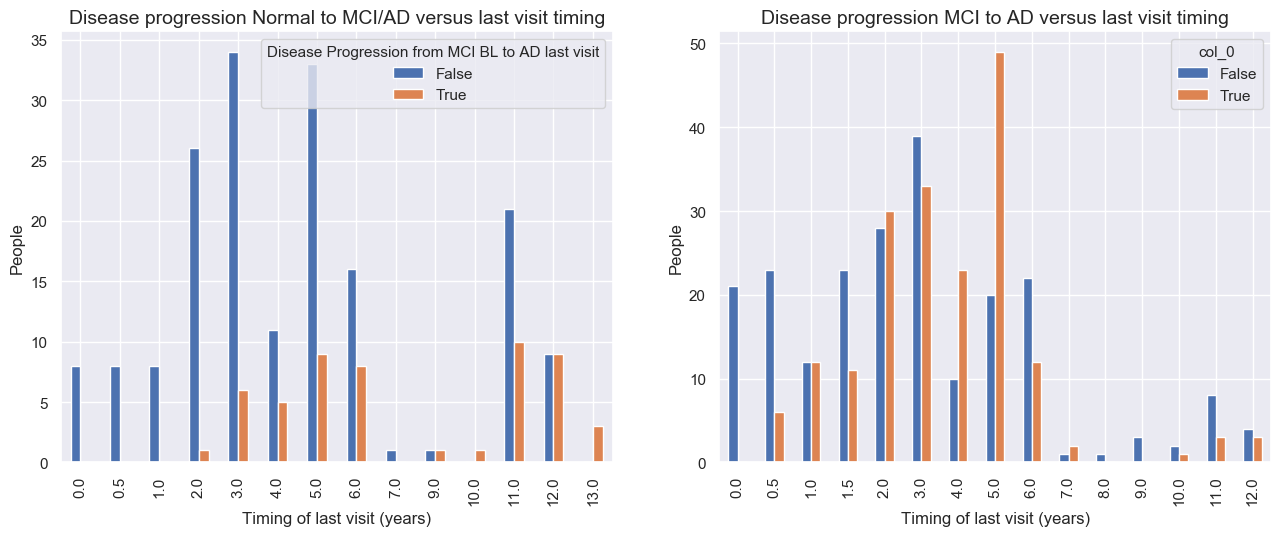

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5.5))
ax1, ax2 = ax.ravel()

pd.crosstab(X_1['M']/12,y_1).plot(kind='bar', ax=ax1)
ax1.set_title('Disease progression Normal to MCI/AD versus last visit timing')
ax1.set_xlabel('Timing of last visit (years)')
ax1.set_ylabel('People')
ax1.legend(title='Disease Progression from Normal BL to MCI/AD last visit')

pd.crosstab(X_2['M']/12,y_2).plot(kind='bar', ax=ax2)
ax2.set_title('Disease progression MCI to AD versus last visit timing')
ax2.set_xlabel('Timing of last visit (years)')
ax2.set_ylabel('People')
ax1.legend(title='Disease Progression from MCI BL to AD last visit')

fig.tight_layout()

In [23]:
# Code credit: sklearn example
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm_original=cm.copy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=0, fontsize=13)
    ax.set_yticklabels(classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    thresh = 1 / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j]*100, '.0f') +  '%  (' +format(cm_original[i, j], 'd') + ')',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)

    ax.set_title(title, fontsize=15)
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.grid('off')

### 2.1.1 Modelling non-balanced, Normal Baseline, progressing to MCI/AD only based on time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.80 , Test accuracy: 	0.63



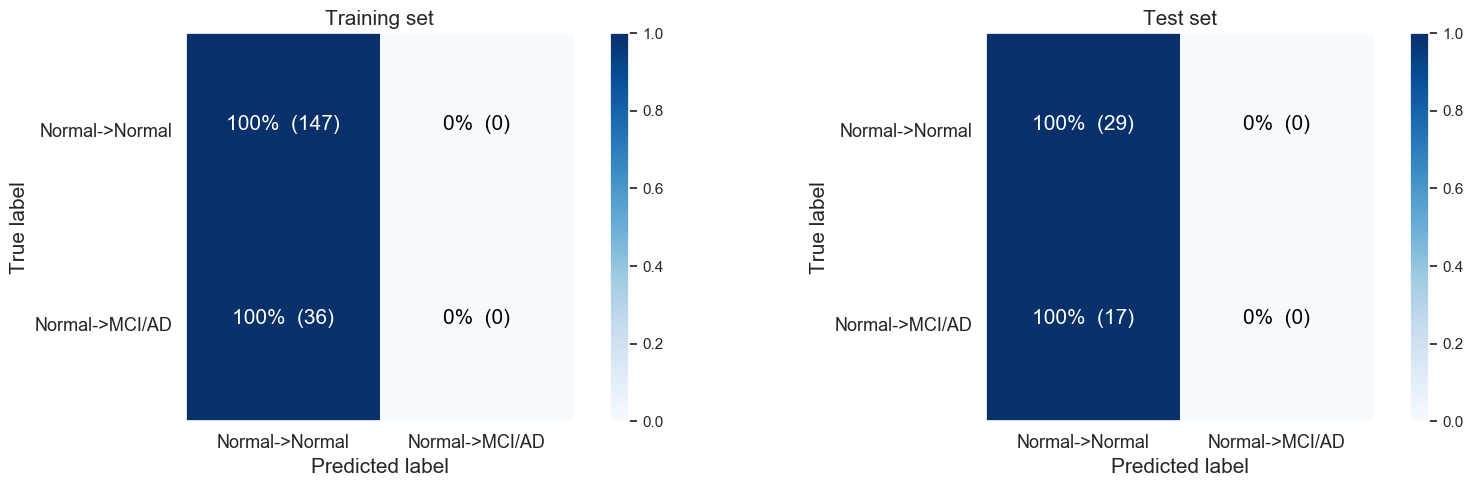

In [136]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear').fit(X_train1['M'].values.reshape(-1,1), y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_1.score(X_train1['M'].values.reshape(-1,1), y_train1), baseline_logreg_1.score(X_test1['M'].values.reshape(-1,1), y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1['M'].values.reshape(-1,1)))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

### 2.1.2 Modelling balanced, Normal Baseline , progressing to MCI/AD only based on time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS  BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.70 , Test accuracy: 	0.70



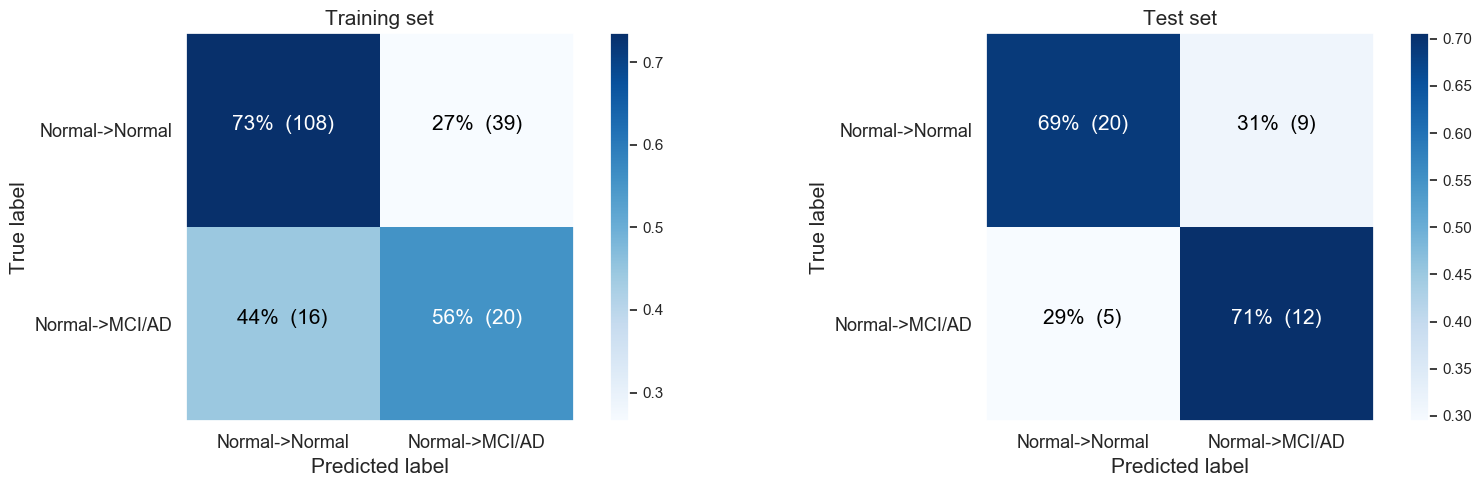

In [137]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS  BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1['M'].values.reshape(-1,1), y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_1.score(X_train1['M'].values.reshape(-1,1), y_train1), baseline_logreg_1.score(X_test1['M'].values.reshape(-1,1), y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1['M'].values.reshape(-1,1)))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

### 2.1.3 Modelling non-balanced, MCI Baseline, progressing to AD only based on time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit
Training accuracy: 	0.58 , Test accuracy: 	0.49



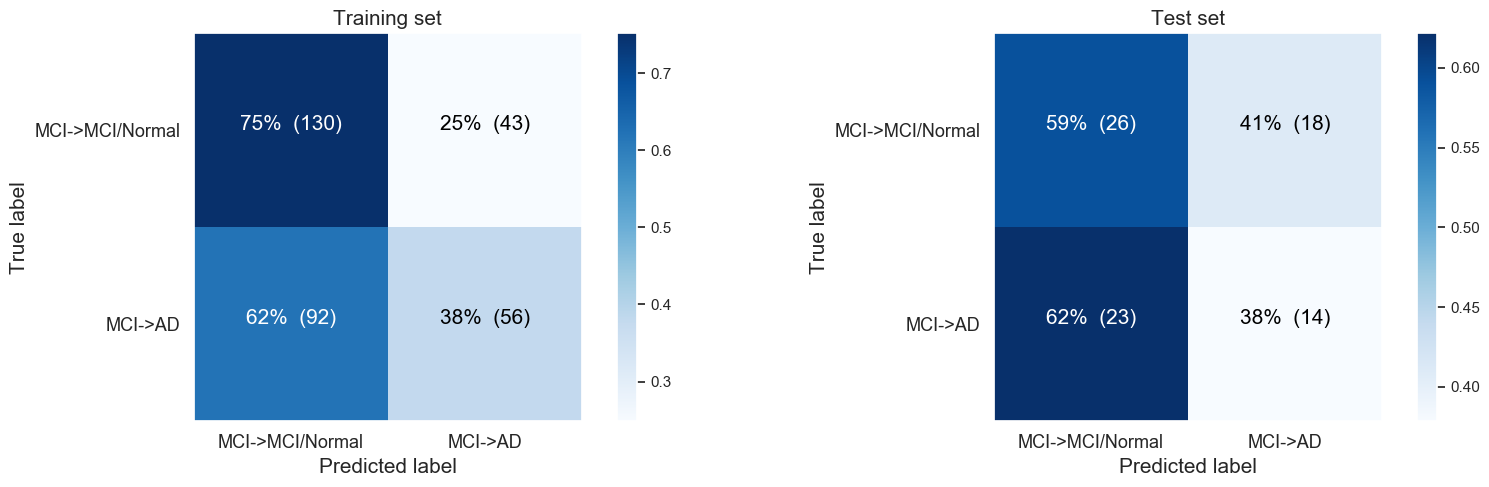

In [138]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')
baseline_logreg_2 = LogisticRegression(solver='liblinear').fit(X_train2['M'].values.reshape(-1,1), y_train2)
print('\nLogistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_2.score(X_train2['M'].values.reshape(-1,1), y_train2), baseline_logreg_2.score(X_test2['M'].values.reshape(-1,1), y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr2 = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2['M'].values.reshape(-1,1)))
cnf_matrix_ts2 = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Test set')
fig.tight_layout()

### 2.1.4 Modelling balanced, MCI Baseline, progressing to AD only based on time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS BALANCED

Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit
Training accuracy: 	0.61 , Test accuracy: 	0.54



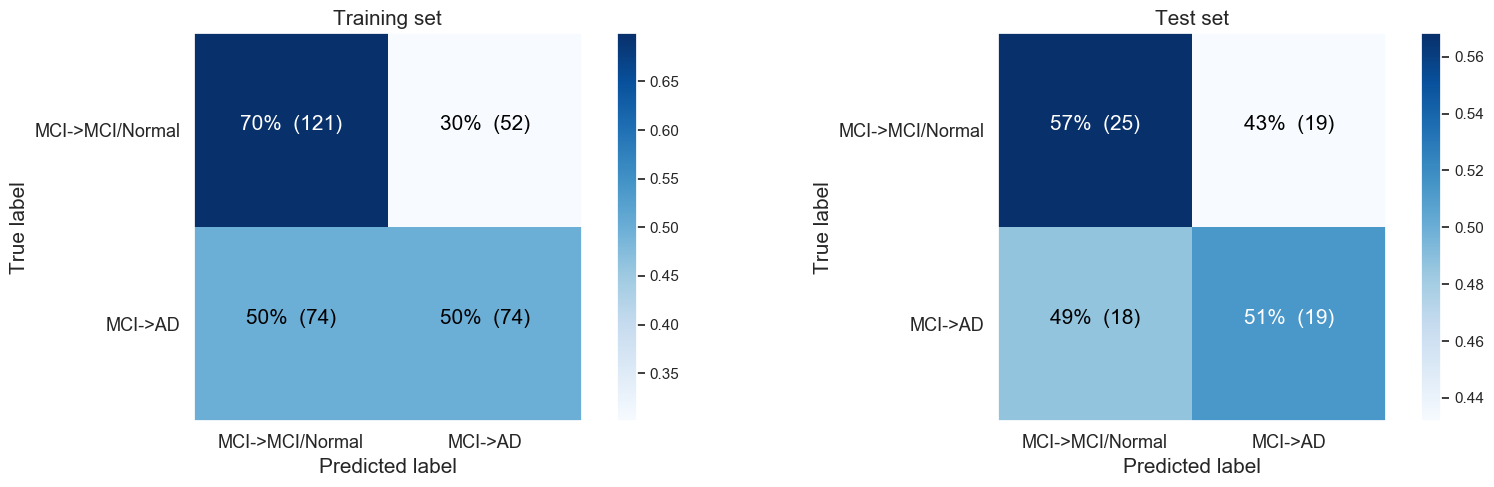

In [139]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS BALANCED')
baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2['M'].values.reshape(-1,1), y_train2)
print('\nLogistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_2.score(X_train2['M'].values.reshape(-1,1), y_train2), baseline_logreg_2.score(X_test2['M'].values.reshape(-1,1), y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr2 = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2['M'].values.reshape(-1,1)))
cnf_matrix_ts2 = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Test set')
fig.tight_layout()

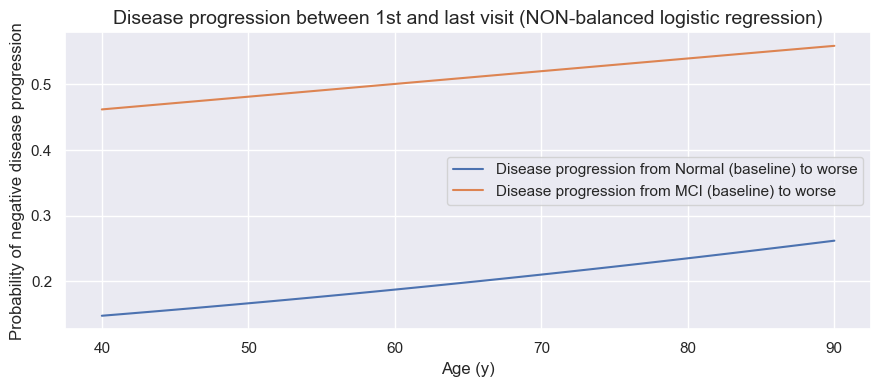

In [145]:
# Plotting regression line of non balanced logistic regression versus age
baseline_logreg_1 = LogisticRegression(solver='liblinear').fit(X_train1['M'].values.reshape(-1,1), y_train1)
baseline_logreg_2 = LogisticRegression(solver='liblinear').fit(X_train2['M'].values.reshape(-1,1), y_train2)

age= np.linspace(start=40, stop=90, num=50)
pred1= baseline_logreg_1.predict_proba(age.reshape(-1,1))[:,1]
pred2= baseline_logreg_2.predict_proba(age.reshape(-1,1))[:,1]

plt.figure(figsize=(9,4))
plt.plot(age, pred1, label='Disease progression from Normal (baseline) to worse')
plt.plot(age, pred2, label='Disease progression from MCI (baseline) to worse')
plt.legend()
plt.title('Disease progression between 1st and last visit (NON-balanced logistic regression)')
plt.xlabel('Age (y)')
plt.ylabel('Probability of negative disease progression');
plt.tight_layout()

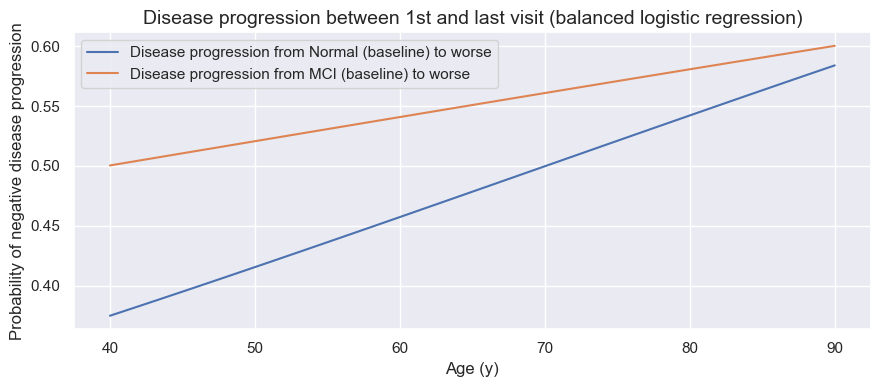

In [143]:
# Plotting regression line of non balanced logistic regression versus age
baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1['M'].values.reshape(-1,1), y_train1)
baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2['M'].values.reshape(-1,1), y_train2)

age= np.linspace(start=40, stop=90, num=50)
pred1= baseline_logreg_1.predict_proba(age.reshape(-1,1))[:,1]
pred2= baseline_logreg_2.predict_proba(age.reshape(-1,1))[:,1]

plt.figure(figsize=(9,4))
plt.plot(age, pred1, label='Disease progression from Normal (baseline) to worse')
plt.plot(age, pred2, label='Disease progression from MCI (baseline) to worse')
plt.legend()
plt.title('Disease progression between 1st and last visit (balanced logistic regression)')
plt.xlabel('Age (y)')
plt.ylabel('Probability of negative disease progression');
plt.tight_layout()

## 2.2 Logistic model  taking into account all baseline measurements and time till last visit

### 2.2.1 Modelling balanced, Normal Baseline , progressing to MCI/AD taking into account all baseline measurements and time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.75 , Test accuracy: 	0.63



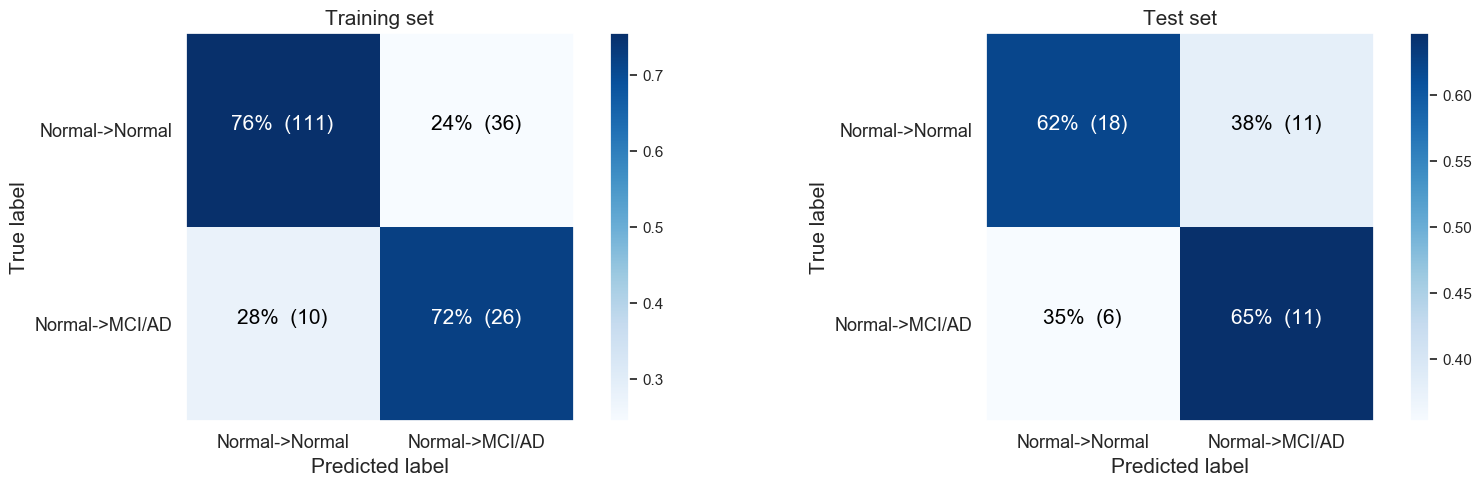

In [146]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1.values, y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_1.score(X_train1.values, y_train1), baseline_logreg_1.score(X_test1.values, y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1.values))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1.values))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

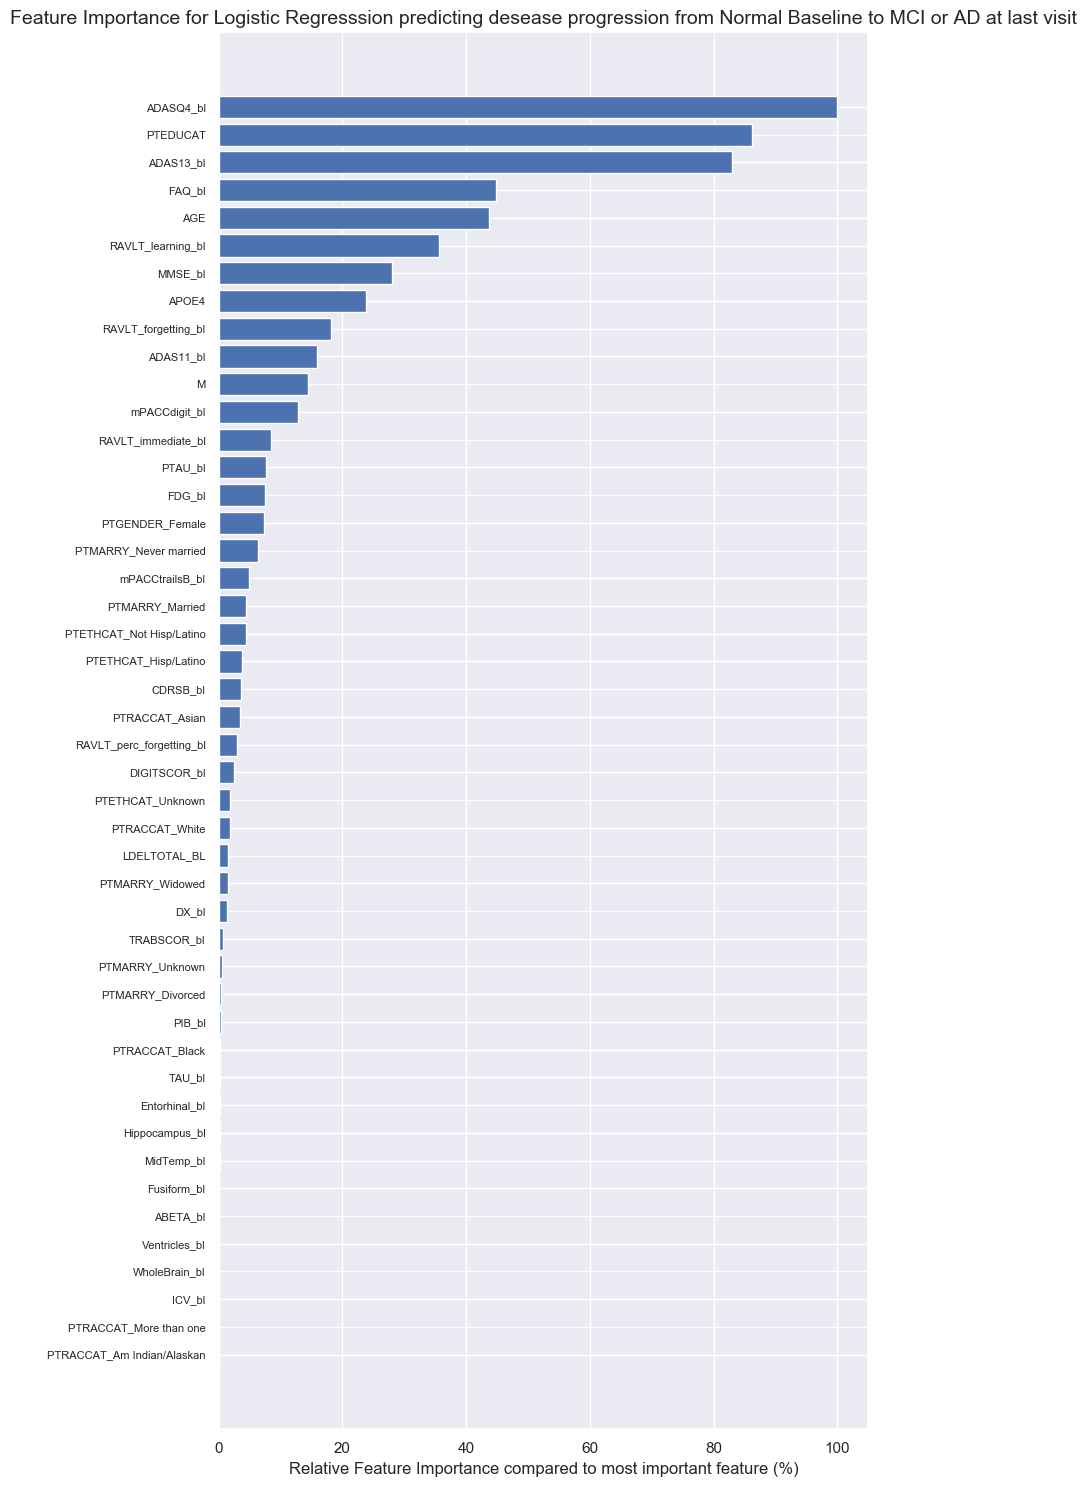

In [147]:
# Feature importance analysis, sort and visualization (for normal baseline model)
feature_importance = abs(baseline_logreg_1.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train1.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance compared to most important feature (%)')
featax.set_title('Feature Importance for Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')

plt.tight_layout()   
plt.show()

### 2.2.2 Modelling balanced, MCI Baseline , progressing to AD taking into account all baseline measurements and time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.76 , Test accuracy: 	0.63



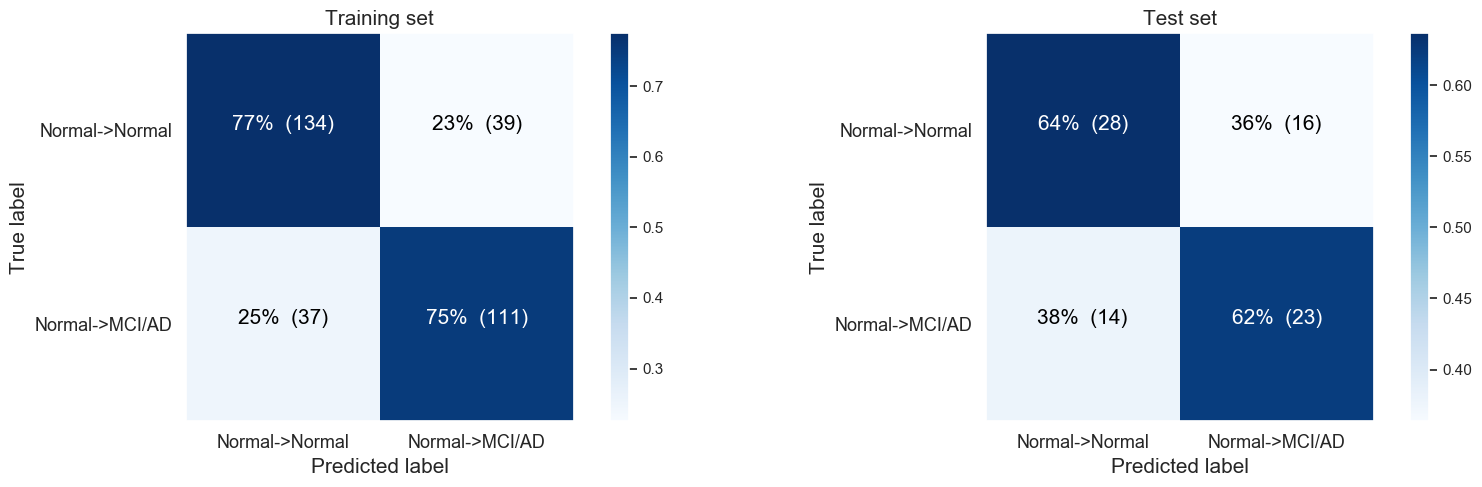

In [148]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2.values, y_train2)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_2.score(X_train2.values, y_train2), baseline_logreg_2.score(X_test2.values, y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2.values))
cnf_matrix_ts = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2.values))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

1. M: 			 Months after BL
2. RAVLT_perc_forget: 	 Percentage forgetting during Reys Auditory Verbal Learning Test
3. FAQ_bl: 		 Functinoal Activities Questionnaire score at BL



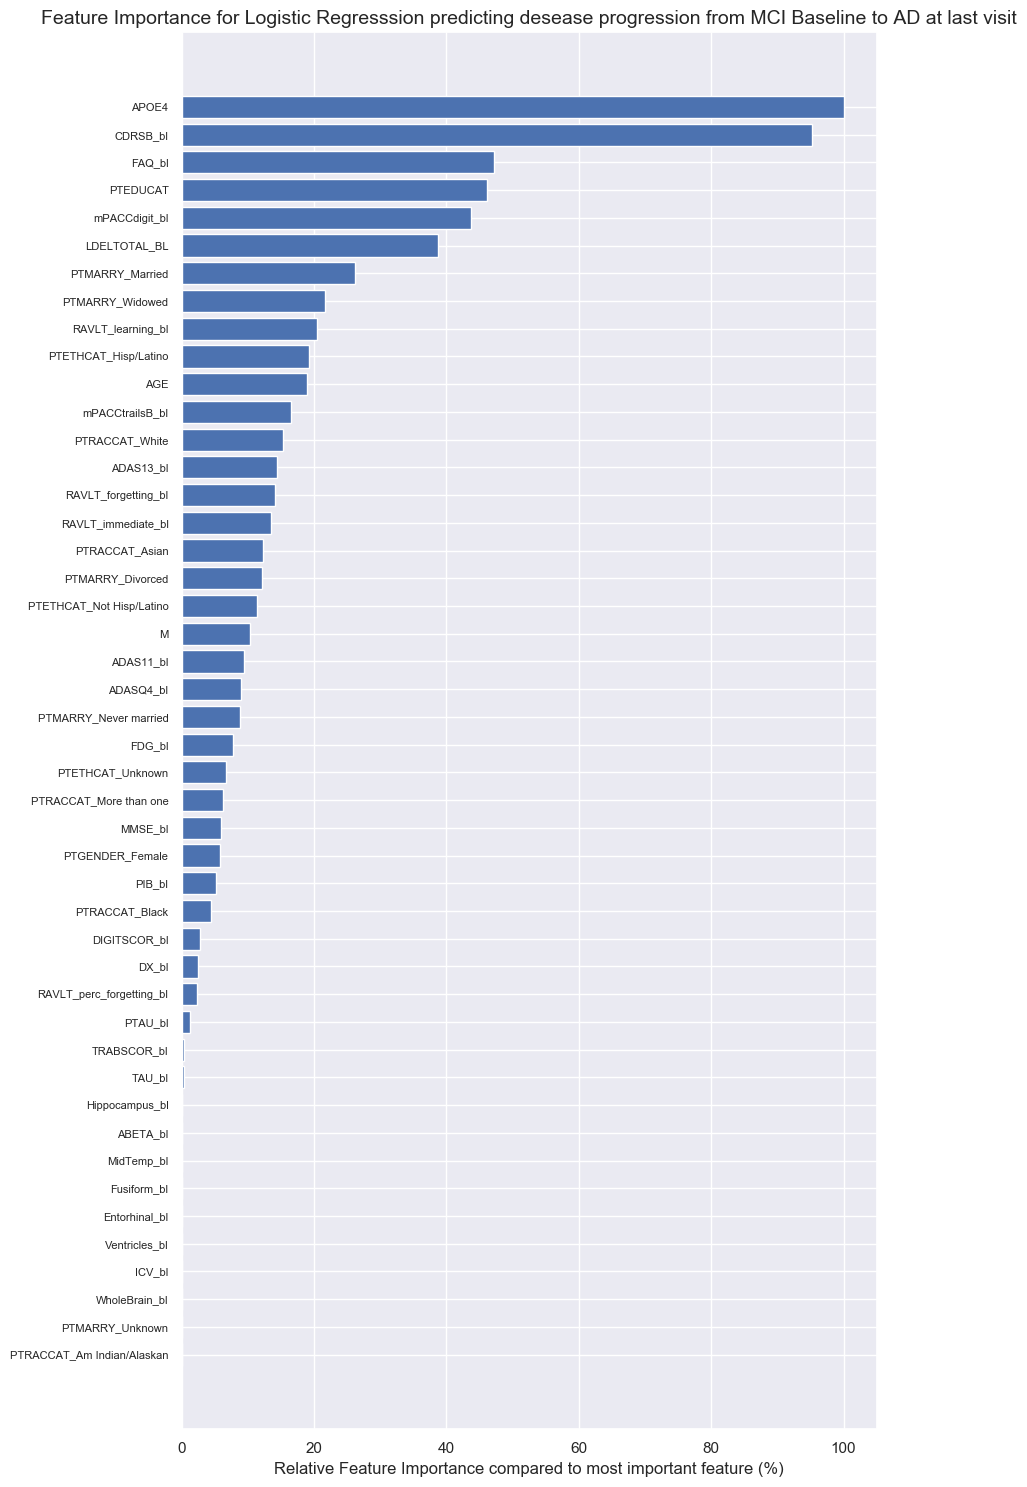

In [150]:
# Feature importance analysis, sort and visualization (for MCI baseline model)
print('1. M: \t\t\t Months after BL')
print('2. RAVLT_perc_forget: \t Percentage forgetting during Reys Auditory Verbal Learning Test')
print('3. FAQ_bl: \t\t Functinoal Activities Questionnaire score at BL\n')

feature_importance = abs(baseline_logreg_2.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train2.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance compared to most important feature (%)')
featax.set_title('Feature Importance for Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
plt.tight_layout()   

# 3 Advanced Model Testing with 4-fold Cross Validation Scoring Reporting with internal CV parameter optimization within training fold

### 3.1 Parameter Optimisation Example
Setting: 
- 5-fold cross validation ( so averages on these 5 test sets will be reported )
- Within every training fold of cross validation we do an internal 4-fold CV to optimise the parameters

In [45]:
X_CV=X_2
y_CV=y_2

Estimator_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
Estimator=LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')

In [46]:
# All 10 parameter optimisations and cross validations of a certain Classifier
# Split the data randomly (stratified) in 10 folds
splits = 4
print("All {} PARAMETER OPTIMISATIONS AND CROSS VALIDATIONS OF THE \"KNeighborsClassifier\" ALGORITHM".format(splits))
strat_kfold_external = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
splitted_indexes_external = strat_kfold_external.split(X_CV, y_CV)

params= [len(Estimator_parameters[param]) for param in Estimator_parameters]
total_params= np.prod(params)

best_index=[]
Sum=[0]*total_params
AP_Score =np.array([])
ROC_Score =np.array([])
Prec_Score =np.array([])
Recall_Score =np.array([])
F1_Score =np.array([])
Sens_Score =np.array([])
Spec_Score =np.array([])
Accuracy_Score =np.array([])

best_predictions_all=np.array([])
test_all=np.array([])
i=1
for train_index_external, test_index_external in splitted_indexes_external:
    i+=1
    print("\nThis is optimisation and CV number {}  \t----------------------------------------------------------------------------".format(i))
    
    # take i’th fold as test set and the other 3 folds together as training set
    X_train, X_test = X_CV.iloc[train_index_external], X_CV.iloc[test_index_external]
    y_train, y_test = y_CV.iloc[train_index_external], y_CV.iloc[test_index_external]    
    # take the training set and split it randomly (stratified) 
    # in an inner training set of 2/3 size and an inner validation set of 1/3 size
        
    # for each of the ML methods
    # for each combination of parameter values
    # train the ML method with specified parameters on inner training set and validate on inner validation set
    # take the combination of parameter values that yields highest performance (e.g. area under PR curve), 
    # also write down this parameter value combination train the ML method with best parameter values on
    # the (outer) training set and test on the (outer) test set
                
    mod=clone(Estimator)
    optimisation_param_AP = GridSearchCV(estimator=mod, param_grid=Estimator_parameters, cv=3, verbose=0, scoring='accuracy')
    optimisation_param_AP.fit(X_train, y_train)
    print('Mean scores: \t\t\t\t{}'.format((optimisation_param_AP.cv_results_['mean_test_score']).round(2)))
    print('Differences best - other scores:\t{}'.format((optimisation_param_AP.best_score_-optimisation_param_AP.cv_results_['mean_test_score']).round(2)))
    print('The best paremeters set was\t \tSet {}: {}'.format(optimisation_param_AP.best_index_ +1, optimisation_param_AP.best_params_))
    best_index.append(optimisation_param_AP.best_index_+1)
    Sum=Sum+(optimisation_param_AP.cv_results_['mean_test_score']).round(2)
    
    # Building Random Forest Estimator with best parameters
    best= optimisation_param_AP.best_estimator_
    best.fit(X_train, y_train)
    best_predictions = best.predict_proba(X_test)[:,1]
    best_predictions=best_predictions
    Average_precision_score=average_precision_score(y_test, best_predictions)
    best_predictions_binary =  best.predict(X_test)
    t=confusion_matrix(y_test, best_predictions_binary)
    sensitivity=(t[1][1]/(t[1][0]+t[1][1]))
    specificity=(t[0][0]/(t[0][1]+t[0][0]))
    AP_Score =np.append(AP_Score , Average_precision_score)
    ROC_Score =np.append(ROC_Score , roc_auc_score(y_test, best_predictions))
    Prec_Score =np.append(Prec_Score , precision_score(y_test, best_predictions_binary))
    Recall_Score =np.append(Recall_Score , recall_score(y_test, best_predictions_binary))
    F1_Score =np.append(F1_Score , f1_score(y_test, best_predictions_binary))
    Sens_Score =np.append(Sens_Score , sensitivity)
    Spec_Score =np.append(Spec_Score , specificity)
    Accuracy_Score =np.append(Accuracy_Score , accuracy_score(y_test, best_predictions_binary))
    
    best_predictions_all=np.append(best_predictions_all,best_predictions)
    test_all=np.append(test_all,y_test)
    print('Validation Accuracy score: \t\t{}'.format(Accuracy_Score .round(2)))

All 4 PARAMETER OPTIMISATIONS AND CROSS VALIDATIONS OF THE "KNeighborsClassifier" ALGORITHM

This is optimisation and CV number 2  	----------------------------------------------------------------------------
Mean scores: 				[0.71 0.71 0.72 0.71 0.72 0.71 0.71]
Differences best - other scores:	[0.01 0.01 0.   0.01 0.   0.01 0.01]
The best paremeters set was	 	Set 3: {'C': 0.1}
Validation Accuracy score: 		[0.69]

This is optimisation and CV number 3  	----------------------------------------------------------------------------
Mean scores: 				[0.71 0.71 0.7  0.69 0.7  0.69 0.72]
Differences best - other scores:	[0.01 0.01 0.02 0.03 0.02 0.03 0.  ]
The best paremeters set was	 	Set 7: {'C': 1000}
Validation Accuracy score: 		[0.69 0.73]

This is optimisation and CV number 4  	----------------------------------------------------------------------------
Mean scores: 				[0.68 0.69 0.69 0.68 0.7  0.68 0.68]
Differences best - other scores:	[0.02 0.01 0.01 0.02 0.   0.02 0.02]
The best pa

Note on *Average Precision Score*: scoring='average_precision' = sklearn.metrics.average_precision_score. Compute average precision (AP) from prediction scores AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold.


In [47]:
print('____________________________________________________________________________________________________________________\n') 
Avg=Sum/splits
print('Average of {} splits mean_test_score for all 8 parameter sets:\n{}'.format(splits, Avg.round(2)))
print('Differences best Average - Average for all 8 parameter sets:\n{}'.format((Avg.max()-Avg).round(2)))
print('Best Average mean_test_score = {} for the {}th parameter: {}'.format(round(Avg.max(),2), Avg.argmax()+1, optimisation_param_AP.cv_results_['params'][Avg.argmax()]))
print('Best Parameter Set for all {} splits: {}'.format(splits,best_index))
print('Occurences of all 8 parameters as Best Parameter Set in a split: {}'.format(Counter(best_index)))

____________________________________________________________________________________________________________________

Average of 4 splits mean_test_score for all 8 parameter sets:
[0.7 0.7 0.7 0.7 0.7 0.7 0.7]
Differences best Average - Average for all 8 parameter sets:
[0.01 0.   0.   0.01 0.   0.01 0.01]
Best Average mean_test_score = 0.7 for the 2th parameter: {'C': 0.01}
Best Parameter Set for all 4 splits: [3, 7, 5, 2]
Occurences of all 8 parameters as Best Parameter Set in a split: Counter({3: 1, 7: 1, 5: 1, 2: 1})


### 3.2 Model Performance and Area Under The Receiver Operating Characteristic Curve

In [48]:
print('____________________________________________________________________________________________________________________\n') 
print('Estimator : All {} Accuracy Scores of validation on the outer test set \nwith the estimator with the optimised parameters trained on the inner test set: \n{}'.format(splits, Accuracy_Score))
print('\n\t\tAvg \t(+- STD  )\n\t\t-----------------\nAccuracy: \t{} \t(+- {}) '.format(round(Accuracy_Score.mean(),3), round(Accuracy_Score.std(),3)))

____________________________________________________________________________________________________________________

Estimator : All 4 Accuracy Scores of validation on the outer test set 
with the estimator with the optimised parameters trained on the inner test set: 
[0.68627451 0.73       0.72       0.7       ]

		Avg 	(+- STD  )
		-----------------
Accuracy: 	0.709 	(+- 0.017) 


In [49]:
d={}
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['Logistic_mu'] = [AP_Score.mean(), ROC_Score.mean(), Prec_Score.mean(), Recall_Score.mean(), F1_Score.mean(), Sens_Score.mean(), Spec_Score.mean(), Accuracy_Score.mean()]
d['Logistic_std'] = [AP_Score.std(), ROC_Score.std(), Prec_Score.std(), Recall_Score.std(), F1_Score.std(), Sens_Score.std(), Spec_Score.std(), Accuracy_Score.std()]
df = pd.DataFrame(data=d, index=Names)
#decimals = pd.Series([2, 3], index=['Logistic_mu', 'Logistic_std'])
#df.round(decimals)
df.round(2)

,Logistic_mu,Logistic_std
Average Precision,0.76,0.02
AUROC,0.78,0.01
Precision,0.68,0.03
Recall,0.70,0.08
F1_Score,0.69,0.03
Sensitivity,0.70,0.08
Specificity,0.72,0.06
Accuracy,0.71,0.02


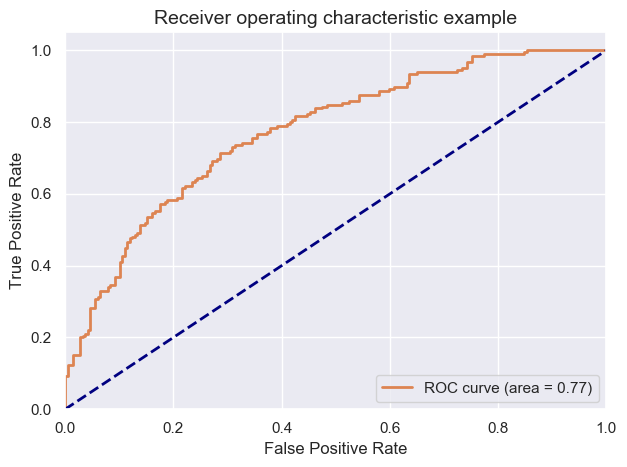

In [151]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(test_all[:], best_predictions_all[:])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='C1', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.tight_layout()

### 3.2bis Parameter Optimisation and 5-fold CV wrapper function

In [54]:
def CV_and_Parameter_Optimization(X_CV, y_CV, splits, Estimator, Estimator_parameters):
  # All 10 parameter optimisations and cross validations of a certain Classifier
  strat_kfold_external = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
  splitted_indexes_external = strat_kfold_external.split(X_CV, y_CV)
  params= [len(Estimator_parameters[param]) for param in Estimator_parameters]
  total_params= np.prod(params)
  best_index=[]
  Sum=[0]*total_params
  AP_Score =np.array([])
  ROC_Score =np.array([])
  Prec_Score =np.array([])
  Recall_Score =np.array([])
  F1_Score =np.array([])
  Sens_Score =np.array([])
  Spec_Score =np.array([])
  Accuracy_Score =np.array([])

  best_predictions_all=np.array([])
  test_all=np.array([])
  i=1
  for train_index_external, test_index_external in splitted_indexes_external:
      print("This is parameter optimisation and CV number {} ...".format(i))
      i=i+1
      # take i’th fold as test set and the other 3 folds together as training set
      X_train, X_test = X_CV.iloc[train_index_external], X_CV.iloc[test_index_external]
      y_train, y_test = y_CV.iloc[train_index_external], y_CV.iloc[test_index_external]    
      # take the training set and split it randomly (stratified) 
      # in an inner training set of 2/3 size and an inner validation set of 1/3 size

      # for each of the ML methods
      # for each combination of parameter values
      # train the ML method with specified parameters on inner training set and validate on inner validation set
      # take the combination of parameter values that yields highest performance (e.g. area under PR curve), 
      # also write down this parameter value combination train the ML method with best parameter values on
      # the (outer) training set and test on the (outer) test set

      mod=clone(Estimator)
      optimisation_param_AP = GridSearchCV(estimator=mod, param_grid=Estimator_parameters, cv=3, verbose=0, scoring='accuracy')
      optimisation_param_AP.fit(X_train, y_train)
      best_index.append(optimisation_param_AP.best_index_+1)
      Sum=Sum+(optimisation_param_AP.cv_results_['mean_test_score']).round(2)

      # Building Estimator with best parameters
      best= optimisation_param_AP.best_estimator_
      best.fit(X_train, y_train)
      best_predictions = best.predict_proba(X_test)[:,1]
      best_predictions=best_predictions
      Average_precision_score=average_precision_score(y_test, best_predictions)
      best_predictions_binary =  best.predict(X_test)
      t=confusion_matrix(y_test, best_predictions_binary)
      sensitivity=(t[1][1]/(t[1][0]+t[1][1]))
      specificity=(t[0][0]/(t[0][1]+t[0][0]))
      AP_Score =np.append(AP_Score , Average_precision_score)
      ROC_Score =np.append(ROC_Score , roc_auc_score(y_test, best_predictions))
      Prec_Score =np.append(Prec_Score , precision_score(y_test, best_predictions_binary))
      Recall_Score =np.append(Recall_Score , recall_score(y_test, best_predictions_binary))
      F1_Score =np.append(F1_Score , f1_score(y_test, best_predictions_binary))
      Sens_Score =np.append(Sens_Score , sensitivity)
      Spec_Score =np.append(Spec_Score , specificity)
      Accuracy_Score =np.append(Accuracy_Score , accuracy_score(y_test, best_predictions_binary))

      best_predictions_all=np.append(best_predictions_all,best_predictions)
      test_all=np.append(test_all,y_test)
  
  print('Done: Validation Accuracy score: \t\t{}'.format(Accuracy_Score .round(3)))
  return AP_Score,  ROC_Score,  Prec_Score,  Recall_Score,  F1_Score,  Sens_Score, Spec_Score, Accuracy_Score,  best_predictions_all, test_all


In [55]:
LOGI_AP=np.array([])    ;  LOGI_ROC=np.array([])     ;  LOGI_Prec=np.array([])
LOGI_Recall=np.array([]);  LOGI_F1=np.array([])      ;  LOGI_Sens=np.array([])
LOGI_Spec=np.array([])  ;  LOGI_Accuracy=np.array([]);  LOGI_binary_mean=np.array([])
LOGI_best_predictions_all=np.array([])               ;  LOGI_test_all=np.array([])

Estimator_parameters = {'C':[1] }
Estimator=LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')

LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, Estimator, Estimator_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.676 0.73  0.73  0.7  ]


In [56]:
d={} # dictionarry with all the results
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['0 Logistic_mu_default'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean()]
d['a Logistic_std_default'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,0 Logistic_mu_default,a Logistic_std_default
Average Precision,0.75,0.01
AUROC,0.78,0.01
Precision,0.68,0.03
Recall,0.71,0.08
F1_Score,0.69,0.03
Sensitivity,0.71,0.08
Specificity,0.71,0.06
Accuracy,0.71,0.02


### Preprocessing: Scaling 

In [57]:
X_CV  = X_2
y_CV  = y_2

In [58]:
X_std = (X_CV - X_CV.min(axis=0)) / (X_CV.max(axis=0) - X_CV.min(axis=0))
X_CV  = X_std.dropna(axis=1).copy()

## 3.3 Model Performance testing

#### 3.3.1 KNN
``` class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
 leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1, **kwargs)````

Test parameters:
- n_neighbors: 1, 3, 5, 9
- p: 1, 2 (manhattan and euclidean distance)

In [59]:
KNN_parameters = {'p':[1,2], 'n_neighbors':[1, 3, 5, 9]}
KNN = KNeighborsClassifier(weights='distance')

In [60]:
KNN_AP=np.array([])    ;  KNN_ROC=np.array([])     ;  KNN_Prec=np.array([])
KNN_Recall=np.array([]);  KNN_F1=np.array([])      ;  KNN_Sens=np.array([])
KNN_Spec=np.array([])  ;  KNN_Accuracy=np.array([]);  KNN_binary_mean=np.array([])
KNN_best_predictions_all=np.array([])               ;  KNN_test_all=np.array([])

KNN_AP,  KNN_ROC,  KNN_Prec,  KNN_Recall,  KNN_F1,  KNN_Sens, KNN_Spec, \
KNN_Accuracy,  KNN_best_predictions_all,  KNN_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, KNN, KNN_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.676 0.68  0.76  0.69 ]


In [122]:
d={} # dictionarry with all the results
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['1 KNN_mu'] = [KNN_AP.mean(),  KNN_ROC.mean(),  KNN_Prec.mean(),  KNN_Recall.mean(),  KNN_F1.mean(),  KNN_Sens.mean(), KNN_Spec.mean(), KNN_Accuracy.mean()]
d['1 KNN_std'] = [KNN_AP.std(),  KNN_ROC.std(),  KNN_Prec.std(),  KNN_Recall.std(),  KNN_F1.std(),  KNN_Sens.std(), KNN_Spec.std(), KNN_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std
Average Precision,0.69,0.05
AUROC,0.76,0.06
Precision,0.67,0.07
Recall,0.74,0.07
F1_Score,0.70,0.02
Sensitivity,0.74,0.07
Specificity,0.67,0.11
Accuracy,0.70,0.03


#### 3.3.2 Logistic Regression
```class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001,  C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,  solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)```

Test parameters:
- solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
- C: 0.001,0.01,0.1,1,10,100,1000 


In [62]:
LOGI_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
LOGI =LogisticRegression(random_state=1,max_iter=1000,tol=5e-4, solver='liblinear', class_weight='balanced')

In [63]:
LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, LOGI, LOGI_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.627 0.66  0.72  0.71 ]


In [123]:
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['2 LOGI_mu'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean()]
d['2 LOGI_std'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std
Average Precision,0.69,0.05,0.74,0.05
AUROC,0.76,0.06,0.77,0.04
Precision,0.67,0.07,0.65,0.06
Recall,0.74,0.07,0.71,0.09
F1_Score,0.70,0.02,0.67,0.03
Sensitivity,0.74,0.07,0.71,0.09
Specificity,0.67,0.11,0.65,0.12
Accuracy,0.70,0.03,0.68,0.04


#### 3.3.3 SVM
``` class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None) ```

Test parameters:
-  C: 0.001,0.01,0.1,1,10,100,1000 
- gamma = 0.001,0.01,0.1,1

In [65]:
SVC_parameters = {'C':[0.1,1,10], 'gamma':[0.01,0.1,1] }
svc=SVC(probability=True,random_state=1,class_weight='balanced', cache_size=20000,kernel='rbf')

In [66]:
SVC_AP,  SVC_ROC,  SVC_Prec,  SVC_Recall,  SVC_F1,  SVC_Sens, SVC_Spec, \
SVC_Accuracy,  SVC_best_predictions_all,  SVC_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, svc, SVC_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.716 0.67  0.73  0.71 ]


In [67]:
#d['3 SVC_mu'] = [SVC_AP.mean(),  SVC_ROC.mean(),  SVC_Prec.mean(),  SVC_Recall.mean(),  SVC_F1.mean(),  SVC_Sens.mean(), SVC_Spec.mean(), SVC_Accuracy.mean()]
#d['c SVC_std'] = [SVC_AP.std(),  SVC_ROC.std(),  SVC_Prec.std(),  SVC_Recall.std(),  SVC_F1.std(),  SVC_Sens.std(), SVC_Spec.std(), SVC_Accuracy.std()]
#df = pd.DataFrame(data=d, index=Names)
#df.round(2)

print("SVC never converges...")

SVC never converges...


#### 3.3.4 Decision Tree
```class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)```

Test parameters:
- max depth = 2, 3, 4, ..., 13, 14, 15

In [68]:
TREE_parameters ={ 'max_depth':range(2,15,2) }    
TREE = DecisionTreeClassifier(random_state=1)

In [69]:
TREE_AP,  TREE_ROC,  TREE_Prec,  TREE_Recall,  TREE_F1,  TREE_Sens, TREE_Spec, \
TREE_Accuracy,  TREE_best_predictions_all,  TREE_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, TREE, TREE_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.647 0.68  0.61  0.61 ]


In [124]:
d['3 TREE_mu'] = [TREE_AP.mean(),  TREE_ROC.mean(),  TREE_Prec.mean(),  TREE_Recall.mean(),  TREE_F1.mean(),  TREE_Sens.mean(), TREE_Spec.mean(), TREE_Accuracy.mean()]
d['3 TREE_std'] = [TREE_AP.std(),  TREE_ROC.std(),  TREE_Prec.std(),  TREE_Recall.std(),  TREE_F1.std(),  TREE_Sens.std(), TREE_Spec.std(), TREE_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04
AUROC,0.76,0.06,0.77,0.04,0.67,0.03
Precision,0.67,0.07,0.65,0.06,0.61,0.03
Recall,0.74,0.07,0.71,0.09,0.61,0.16
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16
Specificity,0.67,0.11,0.65,0.12,0.66,0.10
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03


#### 3.3.5 Random Forest

```class sklearn.ensemble.RandomForestClassifier(n_estimators=10->100, criterion='gini', 
max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)```

Test parameters:
- n_estimators: 50, 100, 500
- max_features: sqrt(#features), log2(#features):
    #If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    #If “log2”, then max_features=log2(n_features).
- min_samples_leaf: 1, 5

In [71]:
RF_parameters = {'n_estimators':[50, 100, 500], 'max_features':('sqrt', 'log2'), 'min_samples_leaf':[1, 5]}
RF = RandomForestClassifier(random_state=1)

In [72]:
RF_AP,  RF_ROC,  RF_Prec,  RF_Recall,  RF_F1,  RF_Sens, RF_Spec, \
RF_Accuracy,  RF_best_predictions_all,  RF_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, RF, RF_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.735 0.71  0.72  0.69 ]


In [125]:
d['4 RF_mu'] = [RF_AP.mean(),  RF_ROC.mean(),  RF_Prec.mean(),  RF_Recall.mean(),  RF_F1.mean(),  RF_Sens.mean(), RF_Spec.mean(), RF_Accuracy.mean()]
d['4 RF_std'] = [RF_AP.std(),  RF_ROC.std(),  RF_Prec.std(),  RF_Recall.std(),  RF_F1.std(),  RF_Sens.std(), RF_Spec.std(), RF_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std,4 RF_mu,4 RF_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04,0.76,0.02
AUROC,0.76,0.06,0.77,0.04,0.67,0.03,0.79,0.02
Precision,0.67,0.07,0.65,0.06,0.61,0.03,0.70,0.04
Recall,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09,0.68,0.03
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08
Specificity,0.67,0.11,0.65,0.12,0.66,0.10,0.75,0.07
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03,0.71,0.02



#### 3.3.6 Gradient boosting
``` class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
 max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')```

Test parameters:
- n_estimators: 50, 100, 500 
- max_leaf_nodes= 2, 4, 8, 16 
- learning_rate = 1, 0.5, 0.1, 0.05, 0.01

In [74]:
BOOST_parameters = {'n_estimators':[50,100,500],'max_leaf_nodes':[2,4,8,16],'learning_rate':[1, 0.5, 0.1, 0.05, 0.01]}
BOOST=GradientBoostingClassifier(random_state=1)

In [75]:
BOOST_AP,  BOOST_ROC,  BOOST_Prec,  BOOST_Recall,  BOOST_F1,  BOOST_Sens, BOOST_Spec, \
BOOST_Accuracy,  BOOST_best_predictions_all,  BOOST_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, BOOST, BOOST_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.745 0.68  0.75  0.73 ]


In [126]:
d['5 BOOST_mu'] = [BOOST_AP.mean(),  BOOST_ROC.mean(),  BOOST_Prec.mean(),  BOOST_Recall.mean(),  BOOST_F1.mean(),  BOOST_Sens.mean(), BOOST_Spec.mean(), BOOST_Accuracy.mean()]
d['5 BOOST_std'] = [BOOST_AP.std(),  BOOST_ROC.std(),  BOOST_Prec.std(),  BOOST_Recall.std(),  BOOST_F1.std(),  BOOST_Sens.std(), BOOST_Spec.std(), BOOST_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std,4 RF_mu,4 RF_std,5 BOOST_mu,5 BOOST_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04,0.76,0.02,0.78,0.05
AUROC,0.76,0.06,0.77,0.04,0.67,0.03,0.79,0.02,0.80,0.03
Precision,0.67,0.07,0.65,0.06,0.61,0.03,0.70,0.04,0.71,0.05
Recall,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09,0.68,0.03,0.70,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04
Specificity,0.67,0.11,0.65,0.12,0.66,0.10,0.75,0.07,0.75,0.07
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03,0.71,0.02,0.73,0.03


#### 3.3.7. XGBoost
 ``` class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)```

Bases: xgboost.sklearn.XGBModel, object
Implementation of the scikit-learn API for XGBoost classification.

Test parameters:
- max_depth = 3,4,...,9,10 
- min_child_weight =  1,3  
- gamma = [0, 0.1,0.2]
- subsample = 0.6, 0,8 
- colsample_bytree = 0.6, 0,8 
- reg_alpha = [0, 0.005, 0.01, 0.05]

In [77]:
XGB2_parameters ={ 'max_depth':range(3,10,2),'min_child_weight':range(1,3,2),
                   'gamma':[0, 0.1,0.2],'subsample':[i/10.0 for i in range(6,9,2)],
                   'colsample_bytree':[i/10.0 for i in range(6,9,2)], 'reg_alpha':[0, 0.005, 0.01, 0.05]}    
XGB2 = XGBClassifier(random_state=1)

In [78]:
XGB2_AP,  XGB2_ROC,  XGB2_Prec,  XGB2_Recall,  XGB2_F1,  XGB2_Sens, XGB2_Spec, \
XGB2_Accuracy,  XGB2_best_predictions_all,  XGB2_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, XGB2, XGB2_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.725 0.71  0.77  0.71 ]


In [127]:
d['6 XGB2_mu'] = [XGB2_AP.mean(),  XGB2_ROC.mean(),  XGB2_Prec.mean(),  XGB2_Recall.mean(),  XGB2_F1.mean(),  XGB2_Sens.mean(), XGB2_Spec.mean(), XGB2_Accuracy.mean()]
d['6 XGB2_std'] = [XGB2_AP.std(),  XGB2_ROC.std(),  XGB2_Prec.std(),  XGB2_Recall.std(),  XGB2_F1.std(),  XGB2_Sens.std(), XGB2_Spec.std(), XGB2_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std,4 RF_mu,4 RF_std,5 BOOST_mu,5 BOOST_std,6 XGB2_mu,6 XGB2_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02
AUROC,0.76,0.06,0.77,0.04,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03
Precision,0.67,0.07,0.65,0.06,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04
Recall,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01
Specificity,0.67,0.11,0.65,0.12,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02


#### 3.3.8 MLP

```class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)```

Test parameters:
- hidden_layer_sizes: (3, ), (20, ), (50, ), (100, )
- activation: relu, logistic
- alpha = 0.00001, 0.0001, 0.001, 0.09, 0.1, 0.5 and 0.9 (assuming this is the decay parameter in Weng et al)

In [80]:
MLP_parameters = {'activation':('relu', 'logistic'), 'hidden_layer_sizes':[(3, ),(20, ),(20,20 ),(50, ),(50,50 ),(100, )],
                 'alpha':[0.0001,0.001,0.09,0.1,0.5]}
MLP = MLPClassifier(random_state=1, max_iter=500,solver='adam')
# It will give warnings without the increase of the standard max_iterations (200) to 2000
# Tolerance softening from standard tol (1e-4) to (2e-4)

In [81]:
MLP_AP,  MLP_ROC,  MLP_Prec,  MLP_Recall,  MLP_F1,  MLP_Sens, MLP_Spec, \
MLP_Accuracy,  MLP_best_predictions_all,  MLP_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, MLP, MLP_parameters)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.716 0.74  0.77  0.68 ]


In [128]:
d['7 MLP_mu'] = [MLP_AP.mean(),  MLP_ROC.mean(),  MLP_Prec.mean(),  MLP_Recall.mean(),  MLP_F1.mean(),  MLP_Sens.mean(), MLP_Spec.mean(), MLP_Accuracy.mean()]
d['7 MLP_std'] = [MLP_AP.std(),  MLP_ROC.std(),  MLP_Prec.std(),  MLP_Recall.std(),  MLP_F1.std(),  MLP_Sens.std(), MLP_Spec.std(), MLP_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std,4 RF_mu,4 RF_std,5 BOOST_mu,5 BOOST_std,6 XGB2_mu,6 XGB2_std,7 MLP_mu,7 MLP_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02,0.77,0.04
AUROC,0.76,0.06,0.77,0.04,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03,0.79,0.03
Precision,0.67,0.07,0.65,0.06,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04,0.72,0.05
Recall,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02,0.69,0.05
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08
Specificity,0.67,0.11,0.65,0.12,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05,0.77,0.05
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02,0.73,0.03


#### 3.3.9 LGM

```lass lightgbm.Dataset(data, label=None, reference=None, weight=None, group=None, init_score=None, silent=False, feature_name='auto', categorical_feature='auto', params=None, free_raw_data=True)```

Test parameters:
- max_depth = 2, 3, 4, 5, 6, 7, 8, 9,10, 30
- n_estimators = 5, 25, 50

In [83]:
LGBM_params = {'max_depth' : [2,3,4,5,6,7,8,9,10, 30],
                'n_estimators': [5, 25, 50]}
lgbm=LGBMClassifier(random_state=1)

In [84]:
LGBM_AP,  LGBM_ROC,  LGBM_Prec,  LGBM_Recall,  LGBM_F1,  LGBM_Sens, LGBM_Spec, \
LGBM_Accuracy,  LGBM_best_predictions_all,  LGBM_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, lgbm, LGBM_params)

This is parameter optimisation and CV number 1 ...
This is parameter optimisation and CV number 2 ...
This is parameter optimisation and CV number 3 ...
This is parameter optimisation and CV number 4 ...
Done: Validation Accuracy score: 		[0.735 0.71  0.77  0.76 ]


In [158]:
d['8 LGBM_mu'] = [LGBM_AP.mean(),  LGBM_ROC.mean(),  LGBM_Prec.mean(),  LGBM_Recall.mean(),  LGBM_F1.mean(),  LGBM_Sens.mean(), LGBM_Spec.mean(), LGBM_Accuracy.mean()]
d['8 LGBM_std'] = [LGBM_AP.std(),  LGBM_ROC.std(),  LGBM_Prec.std(),  LGBM_Recall.std(),  LGBM_F1.std(),  LGBM_Sens.std(), LGBM_Spec.std(), LGBM_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std,4 RF_mu,4 RF_std,5 BOOST_mu,5 BOOST_std,6 XGB2_mu,6 XGB2_std,7 MLP_mu,7 MLP_std,8 LGBM_mu,8 LGBM_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02,0.77,0.04,0.79,0.03
AUROC,0.76,0.06,0.77,0.04,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03,0.79,0.03,0.81,0.03
Precision,0.67,0.07,0.65,0.06,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04,0.72,0.05,0.73,0.04
Recall,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02,0.69,0.05,0.72,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
Specificity,0.67,0.11,0.65,0.12,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05,0.77,0.05,0.77,0.04
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02,0.73,0.03,0.74,0.02


# 4 Results

In [159]:
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 TREE_mu,3 TREE_std,4 RF_mu,4 RF_std,5 BOOST_mu,5 BOOST_std,6 XGB2_mu,6 XGB2_std,7 MLP_mu,7 MLP_std,8 LGBM_mu,8 LGBM_std
Average Precision,0.69,0.05,0.74,0.05,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02,0.77,0.04,0.79,0.03
AUROC,0.76,0.06,0.77,0.04,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03,0.79,0.03,0.81,0.03
Precision,0.67,0.07,0.65,0.06,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04,0.72,0.05,0.73,0.04
Recall,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
F1_Score,0.70,0.02,0.67,0.03,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02,0.69,0.05,0.72,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
Specificity,0.67,0.11,0.65,0.12,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05,0.77,0.05,0.77,0.04
Accuracy,0.70,0.03,0.68,0.04,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02,0.73,0.03,0.74,0.02


#### Plot of the AUROC curve for all the classifiers

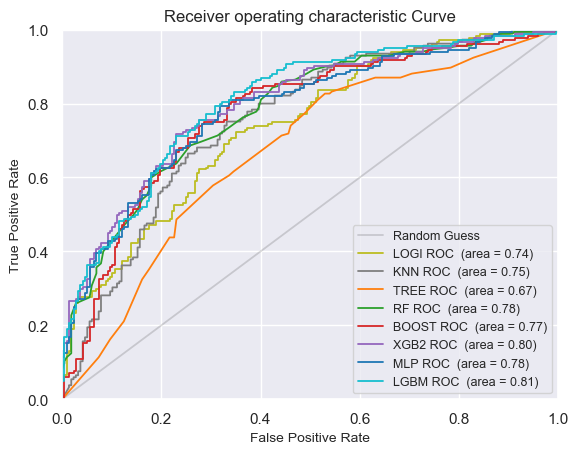

In [160]:
tableau20 = [ (188, 189, 34), (127, 127, 127),(255, 127, 14),(44, 160, 44),(214, 39, 40),  (148, 103, 189), 
             (31, 119, 180), (23, 190, 207), (158, 218, 229), (174, 199, 232), (247, 182, 210), 
             (127, 127, 127), (199, 199, 199), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

ax = plt.subplot(111)
ax.set_prop_cycle('color', tableau20)
plot.tick_params(axis='both', which='major', labelsize=9)
lw = 1.3
plt.plot([0, 1], [0, 1], lw=lw, color='black', alpha=0.15, label='Random Guess')

# Compute ROC curve and ROC area for each class
ll= [ [LOGI_test_all, LOGI_best_predictions_all],
     [KNN_test_all,KNN_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all]]
names=['LOGI', 'KNN', 'TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  fpr = dict; tpr = dict; roc_auc = dict;
  fpr, tpr, _ = roc_curve(l[0][:], l[1][:]) # Calculating false positive rate and false negative rate
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=lw, label=names[i]+' ROC  (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Receiver operating characteristic Curve', fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.show()

#### Plot of the Precision-Recall curve for all the classifiers

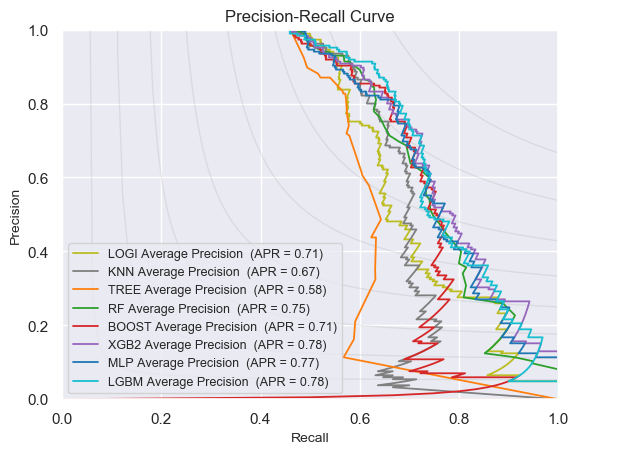

In [161]:
ax = plt.subplot(111)
ax.set_prop_cycle('color', tableau20)
f_scores = np.linspace(0.1, 0.8, num=8)
lines = []
labels = []
lw = 1.3

for f_score in f_scores:
    x = np.linspace(0.001, 1, num=100)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.15, lw=1)
    plt.annotate('f1 = {0:0.1f}'.format(f_score), xy=(1.05, y[80] + 0.01), fontsize=9)

# Compute ROC curve and ROC area for each class
ll= [ [LOGI_test_all, LOGI_best_predictions_all],
     [KNN_test_all,KNN_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all],]

names=['LOGI', 'KNN', 'TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  precision = dict; recall = dict; average_precision = dict;
  precision, recall, _ = precision_recall_curve(l[0][:], l[1][:]) 
  average_precision = average_precision_score(l[0][:], l[1][:])
  plt.plot(precision, recall, lw=lw, label=names[i]+r' Average Precision  (APR = %0.2f)' % average_precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision',fontsize=10)
plt.title('Precision-Recall Curve', fontsize=12)
plt.legend(loc="lower left", fontsize=9)
plt.show()

In [162]:
df.loc['Accuracy'][0::2]

1 KNN_mu      0.701618
2 LOGI_mu     0.679363
3 TREE_mu     0.636765
4 RF_mu       0.713824
5 BOOST_mu    0.726275
6 XGB2_mu     0.728873
7 MLP_mu      0.726422
8 LGBM_mu     0.743824
Name: Accuracy, dtype: float64

In [163]:
names=['KNN', 'LOGI', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
acc_mu=df.loc['Accuracy'][0::2].values
acc_std=df.loc['Accuracy'][1::2].values
dataframe = pd.DataFrame({'mu':acc_mu, 'std':acc_std}, index=names)
dataframe

,mu,std
KNN,0.701618,0.034070
LOGI,0.679363,0.037616
TREE,0.636765,0.029189
RF,0.713824,0.016442
BOOST,0.726275,0.027715
XGB,0.728873,0.024573
MLP,0.726422,0.032991
LGBM,0.743824,0.023258


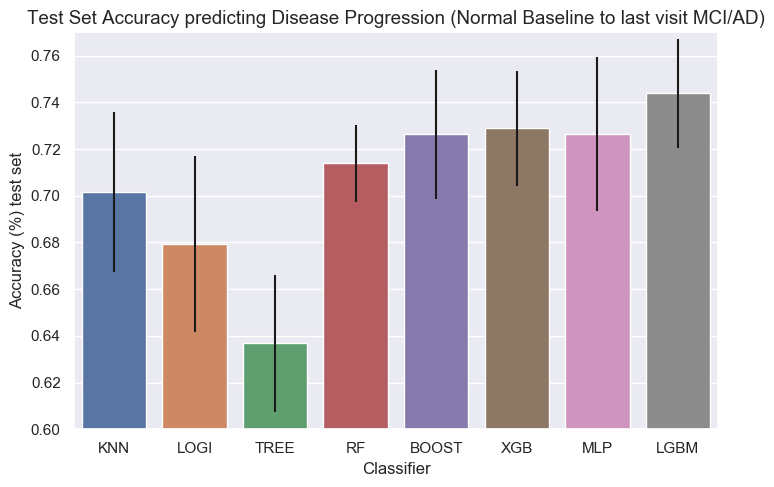

In [179]:
fig, ax= plt.subplots(1,1, figsize=(8,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.mu, ax=ax, yerr=dataframe['std'].values)
ax.set_ylim((0.60, 0.77))
ax.set_title('Test Set Accuracy predicting Disease Progression (Normal Baseline to last visit MCI/AD)', fontsize=13.5)
ax.set_ylabel('Accuracy (%) test set')
ax.set_xlabel('Classifier')
fig.tight_layout()